## Types of roles women portray 

#### What types of characters do women portray and how are these roles linked to their physical profiles?

Rather then depicting the real-life women, cinema tends to perpetuate negative gender stereotypes which are reflected in the roles women play in films.
Some of our hypothesis is that women often receive secondary ad stereotypical representation tied to traditional roles of wives, lovers, mothers....
We think also that they are portrayed as overly emotional or dramatic. Women are rarely identified solely by work-related role in cinema, and thus do no really have identifiable occupations.






### Data handling, preprocessing, descriptive statistics 
In this part we wil explore the characters and their types using the dataset availables in **DATA** that we already started to prepocess in a pervious part: **character_metadata,csv** and the already provided data **tvtropes.clusters.txt**.

Features summary and content:

**character_metadata**
* 1. Wikipedia movie ID
* 2. Freebase movie ID
* 3. Movie release date
* 4. Character name
* 5. Actor date of birth
* 6. Actor gender
* 7. Actor height (in meters)
* 8. Actor ethnicity (Freebase ID)
* 9. Actor name
* 10. Actor age at movie release
* 11. Freebase character/actor map ID
* 12. Freebase character ID
* 13. Freebase actor ID

**tvtropes.clusters.txt**

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import re
import seaborn as sns
import ast

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

### Load the data 

In [3]:
# Load the characters dataset
characters = pd.read_csv('Data/character_metadata.csv')

# Load the tropes dataset as a tab-separated file
tropes = pd.read_csv('Data/MovieSummaries/tvtropes.clusters.txt', sep='\t', header=None, names=['trope', 'data'], engine='python')
# Parse the JSON strings in the 'data' column of the tropes dataset
tropes['data'] = tropes['data'].apply(ast.literal_eval)
# Normalize the 'data' dictionaries into separate columns
data_expanded = pd.json_normalize(tropes['data'])
# Combine the 'trope' column with the expanded data columns
tropes = pd.concat([tropes['trope'], data_expanded], axis=1)


# Load the summaries : read the file into a dataFrame and skips lines with parsing errors
summary = pd.read_csv('Data/MovieSummaries/plot_summaries.txt',sep='\t',header=None, names=['wiki_id', 'summary'], encoding='utf-8', on_bad_lines='skip')
# Convert 'wiki_id' to string 
#summary['wiki_id'] = summary['wiki_id'].astype(str)


### Display the first few rows of each dataframe

In [4]:
print("Tropes dataframe:")
tropes.head()

Tropes dataframe:


,trope,char,movie,id,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [5]:
print("\nCharacters dataframe:")
characters.head()


Characters dataframe:


,Wiki_ID,Movie_ID,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie_released,character/actor_ID,character_ID,Actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [6]:
print("Summary dataframe:")
summary.head()

Summary dataframe:


,wiki_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [9]:
# Ensure the actor column is named consistently in both DataFrames
characters.rename(columns={'actor_name': 'actor'}, inplace=True)

# Create a dictionary mapping from actor to gender
gender_mapping = characters.set_index('actor')['actor_gender'].to_dict()
height_mapping = characters.set_index('actor')['actor_height'].to_dict()
ethnicity_mapping = characters.set_index('actor')['actor_ethnicity'].to_dict()
age_mapping = characters.set_index('actor')['actor_age_movie_released'].to_dict()

# Use the mapping to add the gender column in tropes based on the actor column
tropes['actor_gender'] = tropes['actor'].map(gender_mapping)
tropes['actor_height'] = tropes['actor'].map(height_mapping)
tropes['actor_ethnicity'] = tropes['actor'].map(ethnicity_mapping)
tropes['actor_age_movie_released'] = tropes['actor'].map(age_mapping)

# Display the updated DataFrame
print("Tropes DataFrame with Gender Column Added:")
tropes.head()

Tropes DataFrame with Gender Column Added:


,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M,1.702,NaN,37.0
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,NaN,NaN,35.0
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M,1.800,NaN,63.0
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,NaN,NaN,NaN
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,1.780,NaN,40.0


In [23]:
tropes_w = tropes.loc[tropes['actor_gender'] =='F']
tropes_w.head()


,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz,F,1.70,/m/013b6_,23.0
11,arrogant_kungfu_guy,Jen Yu,"Crouching Tiger, Hidden Dragon",/m/0jwv09,Zhang Ziyi,F,1.63,NaN,28.0
35,brainless_beauty,Gemma Honeycutt,Fool's Gold,/m/04dddz5,Alexis Dziena,F,1.57,/m/0xnvg,18.0
38,brainless_beauty,Shelley Darlingson,The House Bunny,/m/04dgw4t,Anna Faris,F,1.65,/m/07bch9,28.0
39,brainless_beauty,Brace Channing,My Favorite Martian,/m/03lvf22,Elizabeth Hurley,F,1.73,/m/02w7gg,35.0


In [22]:

tropes_m = tropes.loc[tropes['actor_gender'] =='M']
tropes_m.head()

,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M,1.702,NaN,37.0
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,NaN,NaN,35.0
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M,1.800,NaN,63.0
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,NaN,NaN,NaN
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,1.780,NaN,40.0


### Calculating descriptive statistics 
* let's calculate basic descriptive statistics of the trope

In [25]:
tropes_w['trope'].describe()


count              69
unique             21
top       dumb_blonde
freq               10
Name: trope, dtype: object

In [32]:
print('All the tropes we find women in are\n',tropes_w['trope'].unique())

All the tropes we find women in are
 ['adventurer_archaeologist' 'arrogant_kungfu_guy' 'brainless_beauty'
 'broken_bird' 'bully' 'chanteuse' 'classy_cat_burglar' 'ditz' 'doormat'
 'dumb_blonde' 'eccentric_mentor' 'final_girl' 'granola_person'
 'heartbroken_badass' 'junkie_prophet' 'klutz' 'ophelia' 'prima_donna'
 'slacker' 'storyteller' 'valley_girl']


In [26]:
tropes_m['trope'].describe()

count                   431
unique                   65
top       crazy_jealous_guy
freq                     25
Name: trope, dtype: object

In [33]:
print('All the tropes we find women in are\n',tropes_m['trope'].unique())

All the tropes we find women in are
 ['absent_minded_professor' 'adventurer_archaeologist'
 'arrogant_kungfu_guy' 'big_man_on_campus' 'bounty_hunter'
 'brainless_beauty' 'broken_bird' 'bromantic_foil'
 'bruiser_with_a_soft_center' 'bully' 'byronic_hero' 'casanova' 'charmer'
 'child_prodigy' 'consummate_professional' 'corrupt_corporate_executive'
 'coward' 'crazy_jealous_guy' 'crazy_survivalist' 'cultured_badass'
 'dean_bitterman' 'dirty_cop' 'ditz' 'doormat' 'drill_sargeant_nasty'
 'dumb_blonde' 'dumb_muscle' 'eccentric_mentor' 'egomaniac_hunter'
 'evil_prince' 'fastest_gun_in_the_west' 'father_to_his_men'
 'gadgeteer_genius' 'gentleman_thief' 'granola_person' 'grumpy_old_man'
 'hardboiled_detective' 'heartbroken_badass' 'henpecked_husband'
 'hitman_with_a_heart' 'jerk_jock' 'klutz' 'loser_protagonist'
 'loveable_rogue' 'master_swordsman' 'morally_bankrupt_banker'
 'officer_and_a_gentleman' 'playful_hacker' 'psycho_for_hire'
 'pupil_turned_to_evil' 'retired_outlaw' 'revenge' 'romantic_

* Distribution of each trope for both women and men, to see which tropes are more frequently associeted with each gender

In [38]:
tropes_w_distribution = tropes_w['trope'].value_counts(normalize=True) * 100
tropes_m_distribution = tropes_m['trope'].value_counts(normalize=True) * 100

print("Top tropes distribution for women:")
print(tropes_w_distribution.head(10))
print("\nTop tropes distribution for men:")
print(tropes_m_distribution.head(10))

Top tropes distribution for women:
trope
dumb_blonde         14.492754
brainless_beauty    10.144928
valley_girl          8.695652
final_girl           8.695652
chanteuse            8.695652
prima_donna          8.695652
ophelia              7.246377
broken_bird          5.797101
granola_person       5.797101
slacker              2.898551
Name: proportion, dtype: float64

Top tropes distribution for men:
trope
crazy_jealous_guy              5.800464
corrupt_corporate_executive    5.336427
byronic_hero                   3.944316
psycho_for_hire                3.712297
father_to_his_men              3.480278
stoner                         3.016241
master_swordsman               2.784223
hitman_with_a_heart            2.320186
bounty_hunter                  2.320186
warrior_poet                   2.088167
Name: proportion, dtype: float64


* Average age of actors by tropes, to see if certain tropes are associated with different age groupes

In [37]:
average_age_by_trope_w = tropes_w.groupby('trope')['actor_age_movie_released'].mean()
average_age_by_trope_m = tropes_m.groupby('trope')['actor_age_movie_released'].mean()

print("Average age of actors by trope for women:")
print(average_age_by_trope_w)
print("\nAverage age of actors by trope for men:")
print(average_age_by_trope_m)

Average age of actors by trope for women:
trope
adventurer_archaeologist    23.000000
arrogant_kungfu_guy         28.000000
brainless_beauty            26.285714
broken_bird                 27.500000
bully                       20.000000
chanteuse                   33.166667
classy_cat_burglar          22.000000
ditz                        18.000000
doormat                     51.000000
dumb_blonde                 28.800000
eccentric_mentor            51.500000
final_girl                  42.400000
granola_person              24.000000
heartbroken_badass          29.000000
junkie_prophet              20.500000
klutz                       23.000000
ophelia                     23.750000
prima_donna                 26.600000
slacker                     35.500000
storyteller                 13.000000
valley_girl                 27.166667
Name: actor_age_movie_released, dtype: float64

Average age of actors by trope for men:
trope
absent_minded_professor     43.750000
adventurer_archaeologi

* Average Height by Trope

In [39]:
average_height_by_trope_w = tropes_w.groupby('trope')['actor_height'].mean()
average_height_by_trope_m = tropes_m.groupby('trope')['actor_height'].mean()

print("Average height of actors by trope for women:")
print(average_height_by_trope_w)
print("\nAverage height of actors by trope for men:")
print(average_height_by_trope_m)

Average height of actors by trope for women:
trope
adventurer_archaeologist    1.700000
arrogant_kungfu_guy         1.630000
brainless_beauty            1.680714
broken_bird                 1.690000
bully                       1.670000
chanteuse                   1.712833
classy_cat_burglar               NaN
ditz                        1.650000
doormat                          NaN
dumb_blonde                 1.684556
eccentric_mentor            1.540000
final_girl                  1.715000
granola_person              1.695000
heartbroken_badass          1.750000
junkie_prophet              1.615000
klutz                       1.730000
ophelia                     1.630250
prima_donna                 1.580000
slacker                     1.755000
storyteller                 1.700000
valley_girl                 1.664333
Name: actor_height, dtype: float64

Average height of actors by trope for men:
trope
absent_minded_professor     1.760667
adventurer_archaeologist    1.850000
arrogant_kung

* Ethnicity Distribution by Trope

In [40]:
ethnicity_distribution_w = tropes_w.groupby('trope')['actor_ethnicity'].value_counts(normalize=True)
ethnicity_distribution_m = tropes_m.groupby('trope')['actor_ethnicity'].value_counts(normalize=True)

print("Ethnicity distribution by trope for women:")
print(ethnicity_distribution_w)
print("\nEthnicity distribution by trope for men:")
print(ethnicity_distribution_m)

Ethnicity distribution by trope for women:
trope                     actor_ethnicity
adventurer_archaeologist  /m/013b6_          1.000000
brainless_beauty          /m/07bch9          0.200000
                          /m/042gtr          0.200000
                          /m/065b6q          0.200000
                          /m/02w7gg          0.200000
                          /m/0xnvg           0.200000
broken_bird               /m/01qhm_          0.500000
                          /m/04ydrsn         0.500000
chanteuse                 /m/065b6q          0.400000
                          /m/042gtr          0.200000
                          /m/04f581          0.200000
                          /m/07hwkr          0.200000
ditz                      /m/041rx           1.000000
dumb_blonde               /m/07bch9          0.428571
                          /m/0xnvg           0.142857
                          /m/03bkbh          0.142857
                          /m/041rx           0.1428

* Most frequent tropes for women and men 

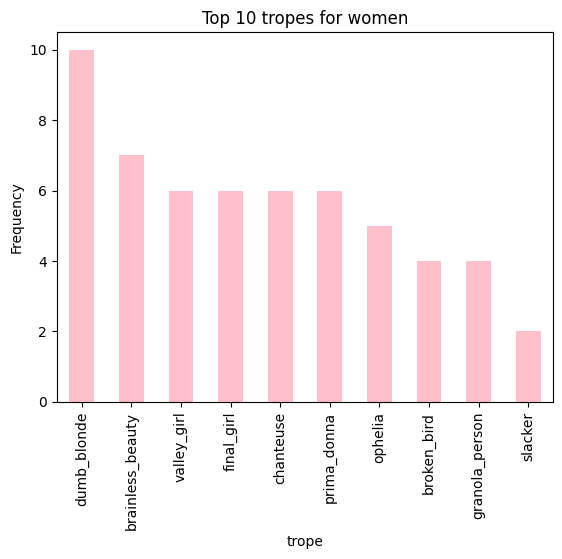

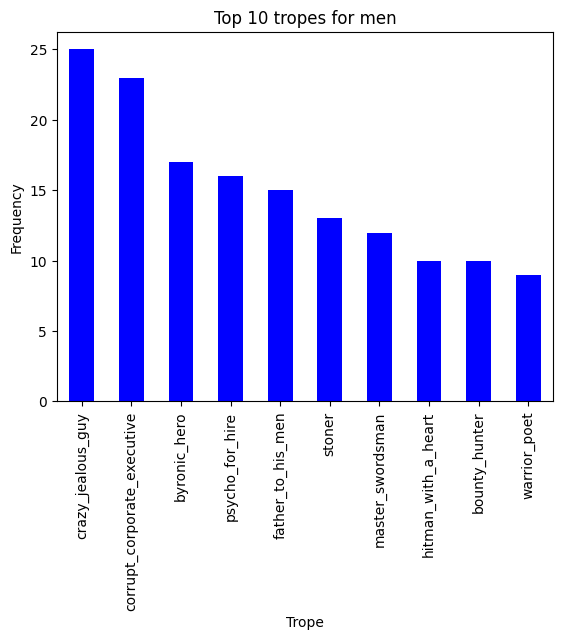

In [49]:
top_tropes_w = tropes_w['trope'].value_counts().head(10)
top_tropes_m = tropes_m['trope'].value_counts().head(10)

# Plotting the top 10 tropes for women and men
top_tropes_w.plot(kind='bar', title='Top 10 tropes for women', color='pink')
plt.ylabel('Frequency')
plt.show()
# Plot the top 10 tropes for men
top_tropes_m.plot(kind='bar', title = 'Top 10 tropes for men',color='blue')
plt.ylabel('Frequency')
plt.xlabel('Trope')
plt.show()